In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

# 1. EDA and Data Cleaning

In [2]:
tr = pd.read_csv('./datasets/train.csv')
tst = pd.read_csv('./datasets/test.csv')

#### Check shape

In [3]:
# check shape
tr.shape

(2051, 81)

#### Reformat column names

In [4]:
# reformat column names
tr.columns = tr.columns.str.replace(' ', '_')
tr.columns = tr.columns.str.lower()

# reformat column names
tst.columns = tst.columns.str.replace(' ', '_')
tst.columns = tst.columns.str.lower()

#### Check for nulls and dtypes

In [5]:
# check for nulls and dtypes
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     1721 non-null   float64
 5   lot_area         2051 non-null   int64  
 6   street           2051 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2051 non-null   object 
 9   land_contour     2051 non-null   object 
 10  utilities        2051 non-null   object 
 11  lot_config       2051 non-null   object 
 12  land_slope       2051 non-null   object 
 13  neighborhood     2051 non-null   object 
 14  condition_1      2051 non-null   object 
 15  condition_2      2051 non-null   object 
 16  bldg_type        2051 non-null   object 
 17  house_style   

#### I used a few heatmaps to find columns of correlations to model with

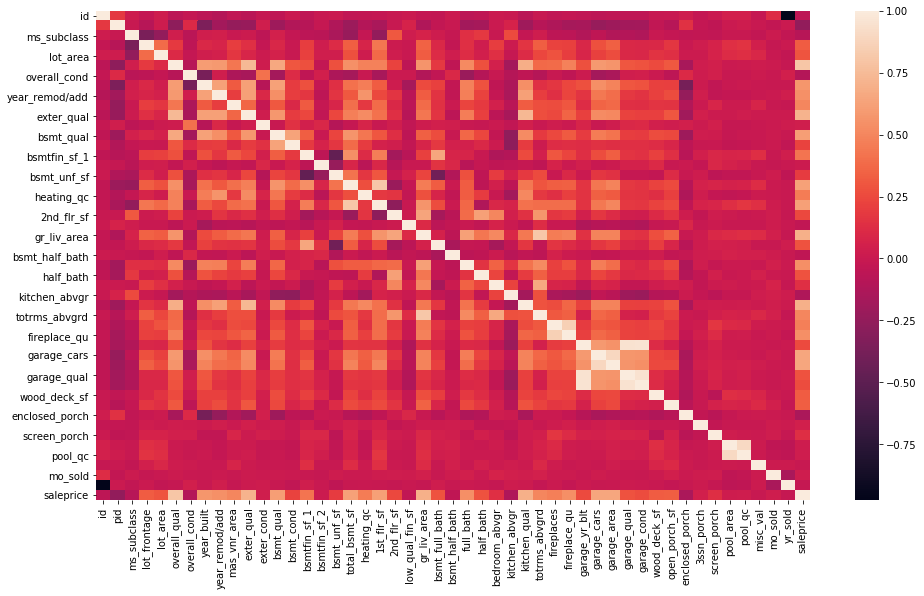

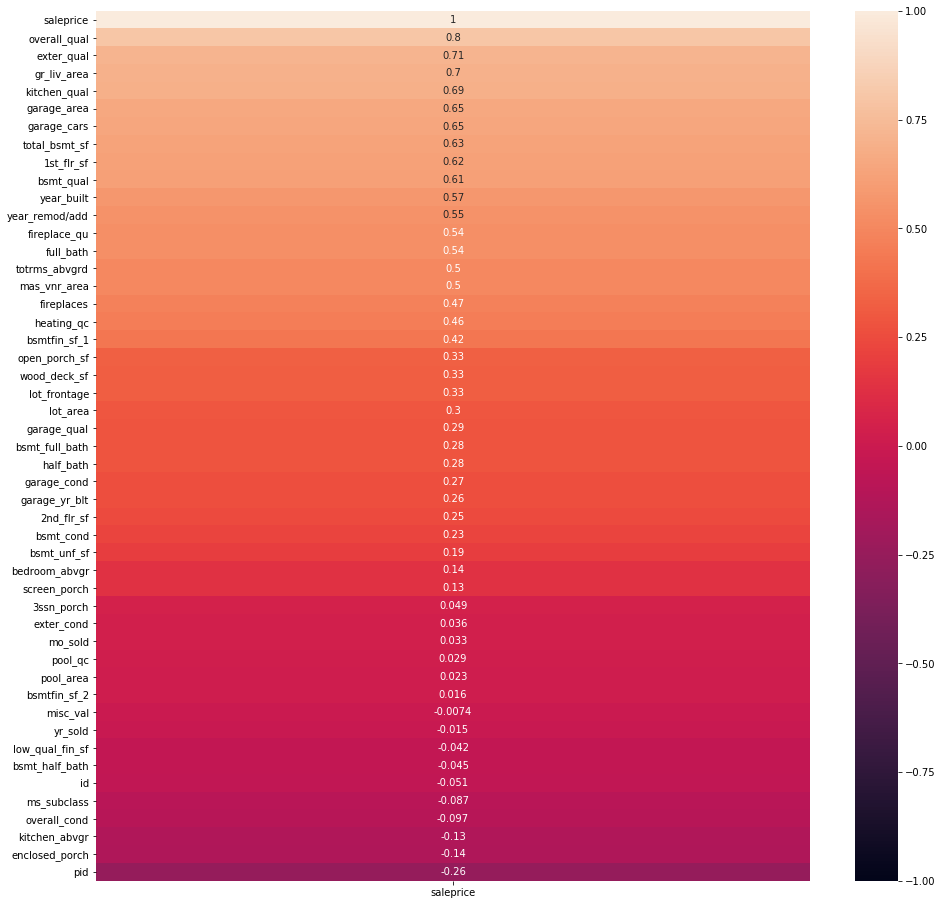

In [71]:
plt.figure(figsize=(16,9))
sns.heatmap(tr.corr());

tr_corr = tr.corr()
plt.figure(figsize=(16,16))
sns.heatmap(tr_corr[['saleprice']].sort_values(by=['saleprice'], ascending=False), vmin=-1, vmax=1, annot=True);

#### Create a list of columns with any nulls

In [7]:
# created a list of columns with any nulls
tr_nulls = list(tr.columns[tr.isnull().any()])

# created a list of columns with any nulls
tst_nulls = list(tst.columns[tst.isnull().any()])

#### Here I loop through the columns created above, and if the dtype is object, I add it to a new list of alpha_nulls, and do the same for numeric dtypes in num_nulls. Then I print out the unique values of the alpha_nulls, so I can check them against the data dictionary.

In [8]:
# loop though those columns, and if the datatype isn't an int/float, add it to a new list
# print the unique values of columns in new list to check against data dictionary
tr_alpha_nulls = []
tr_num_nulls = []
for i in tr_nulls:
    if tr[i].dtypes == 'O':
        tr_alpha_nulls.append(i)
    else:
        tr_num_nulls.append(i)
        print(f'{i} is numeric')
        
for i in tr_alpha_nulls:
    print(f'{i} : {tr[i].unique()}')

# loop though those columns, and if the datatype isn't an int/float, add it to a new list
# print the unique values of columns in new list to check against data dictionary
tst_alpha_nulls = []
tst_num_nulls = []
for i in tst_nulls:
    if tst[i].dtypes == 'O':
        tst_alpha_nulls.append(i)
    else:
        tst_num_nulls.append(i)
        print(f'{i} is numeric')
        
for i in tst_alpha_nulls:
    print(f'{i} : {tst[i].unique()}')

lot_frontage is numeric
mas_vnr_area is numeric
bsmtfin_sf_1 is numeric
bsmtfin_sf_2 is numeric
bsmt_unf_sf is numeric
total_bsmt_sf is numeric
bsmt_full_bath is numeric
bsmt_half_bath is numeric
garage_yr_blt is numeric
garage_cars is numeric
garage_area is numeric
alley : [nan 'Pave' 'Grvl']
mas_vnr_type : ['BrkFace' 'None' nan 'Stone' 'BrkCmn']
bsmt_qual : ['TA' 'Gd' 'Fa' nan 'Ex' 'Po']
bsmt_cond : ['TA' 'Gd' nan 'Fa' 'Po' 'Ex']
bsmt_exposure : ['No' 'Gd' 'Av' nan 'Mn']
bsmtfin_type_1 : ['GLQ' 'Unf' 'ALQ' 'Rec' nan 'BLQ' 'LwQ']
bsmtfin_type_2 : ['Unf' 'Rec' nan 'BLQ' 'GLQ' 'LwQ' 'ALQ']
fireplace_qu : [nan 'TA' 'Gd' 'Po' 'Ex' 'Fa']
garage_type : ['Attchd' 'Detchd' 'BuiltIn' 'Basment' nan '2Types' 'CarPort']
garage_finish : ['RFn' 'Unf' 'Fin' nan]
garage_qual : ['TA' 'Fa' nan 'Gd' 'Ex' 'Po']
garage_cond : ['TA' 'Fa' nan 'Po' 'Gd' 'Ex']
pool_qc : [nan 'Fa' 'Gd' 'Ex' 'TA']
fence : [nan 'MnPrv' 'GdPrv' 'GdWo' 'MnWw']
misc_feature : [nan 'Shed' 'TenC' 'Gar2' 'Othr' 'Elev']
lot_frontage is

# 2. Imputing data

### This is a very brute-force method to imputing, but it is quick and somewhat meaningful. This way at least there is at least some reasoning behind it, and I don't have to drop large numbers of observations, but minimize the effect on the model. Focus is on speed at this point.

#### After checking the data dictionary, it became clear that some of the values were erroneously replaced by nulls when they should just be 'NA'. So here is where I impute the NA's back.

In [9]:
## after checking data dictionary for possible explanations, 
## realized that NA's were replaced by np.nan
# got tired of imputing values by column, used list from above for where 
# nan should be replaced by NA, passed list to loop
for column in tr_alpha_nulls:
    tr[column] = np.where(tr[column].isnull(), 'NA', tr[column])
    print(f'{column}:{tr[column].unique()}')
    
for column in tst_alpha_nulls:
    tst[column] = np.where(tst[column].isnull(), 'NA', tst[column])
    print(f'{column}:{tst[column].unique()}')

alley:['NA' 'Pave' 'Grvl']
mas_vnr_type:['BrkFace' 'None' 'NA' 'Stone' 'BrkCmn']
bsmt_qual:['TA' 'Gd' 'Fa' 'NA' 'Ex' 'Po']
bsmt_cond:['TA' 'Gd' 'NA' 'Fa' 'Po' 'Ex']
bsmt_exposure:['No' 'Gd' 'Av' 'NA' 'Mn']
bsmtfin_type_1:['GLQ' 'Unf' 'ALQ' 'Rec' 'NA' 'BLQ' 'LwQ']
bsmtfin_type_2:['Unf' 'Rec' 'NA' 'BLQ' 'GLQ' 'LwQ' 'ALQ']
fireplace_qu:['NA' 'TA' 'Gd' 'Po' 'Ex' 'Fa']
garage_type:['Attchd' 'Detchd' 'BuiltIn' 'Basment' 'NA' '2Types' 'CarPort']
garage_finish:['RFn' 'Unf' 'Fin' 'NA']
garage_qual:['TA' 'Fa' 'NA' 'Gd' 'Ex' 'Po']
garage_cond:['TA' 'Fa' 'NA' 'Po' 'Gd' 'Ex']
pool_qc:['NA' 'Fa' 'Gd' 'Ex' 'TA']
fence:['NA' 'MnPrv' 'GdPrv' 'GdWo' 'MnWw']
misc_feature:['NA' 'Shed' 'TenC' 'Gar2' 'Othr' 'Elev']
alley:['Grvl' 'NA' 'Pave']
mas_vnr_type:['None' 'BrkFace' 'Stone' 'BrkCmn' 'CBlock' 'NA']
bsmt_qual:['Fa' 'Gd' 'TA' 'Ex' 'NA' 'Po']
bsmt_cond:['TA' 'Gd' 'NA' 'Fa']
bsmt_exposure:['No' 'Av' 'NA' 'Mn' 'Gd']
bsmtfin_type_1:['Unf' 'GLQ' 'BLQ' 'Rec' 'ALQ' 'NA' 'LwQ']
bsmtfin_type_2:['Unf' 'LwQ' 'NA' '

#### The nulls in mas_vnr_area are likely actually 0, as in these houses just don't have any masonry at all. So by filtering the nulls with the rows where mas_vnr_type = NA, I can impute the 0 value for the area.

In [10]:
# filtering for rows with null 'mas_vnr_area', and null 'mas_vnr_type'
# those are likely to actually be 0 (as in they don't have any masonry)
tr_filter_index = tr[(tr['mas_vnr_area'].isnull()) & (tr['mas_vnr_type']=='NA')].index
tst_filter_index = tst[(tst['mas_vnr_area'].isnull()) & (tst['mas_vnr_type']=='NA')].index

# use the list of index from above to put the value at 0
for i in tr_filter_index:
    tr.at[i, 'mas_vnr_area'] = 0
    
for i in tst_filter_index:
    tst.at[i, 'mas_vnr_area'] = 0

#### The rest of the mas_vnr_type are actually probably CBlock, since the data dictionary has no entry for NA.

In [11]:
# mas_vnr_type is an exception to this rule, it already has a "none" value, but is missing it's
# 'CBlock' values acc to data dictionary.
# changed those NA's to CBlock
tr['mas_vnr_type'] = np.where(tr['mas_vnr_type'] == 'NA', 'CBlock', tr['mas_vnr_type'])
tst['mas_vnr_type'] = np.where(tst['mas_vnr_type'] == 'NA', 'CBlock', tst['mas_vnr_type'])

#### Imputing the rest of the numeric columns with 0 because they are probably actually 0 like above.

In [12]:
# removed lot_frontage from list, will impute separately
tr_num_nulls.remove('lot_frontage')
tr_num_nulls.remove('mas_vnr_area')
tst_num_nulls.remove('lot_frontage')
tst_num_nulls.remove('mas_vnr_area')

In [13]:
# impute the value of 0 for the nulls in numerical nulls.
tr[tr_num_nulls] = np.where(tr[tr_num_nulls].isnull(), 0, tr[tr_num_nulls])
tst[tst_num_nulls] = np.where(tst[tst_num_nulls].isnull(), 0, tst[tst_num_nulls])

#### Imputing lot_frontage according to the mean of their neighborhood. This avoids imputing a 0, and since all lots likely have frontage (as I understand it), this makes most sense.

In [14]:
# replace lot_frontage nulls with the mean of lot_frontage (without nulls)
tr['lot_frontage'] = np.where(tr['lot_frontage'].isnull(), tr['lot_frontage'].dropna().mean(), tr['lot_frontage'])
tst['lot_frontage'] = np.where(tst['lot_frontage'].isnull(), tst['lot_frontage'].dropna().mean(), tst['lot_frontage'])

#### Changing the below ranking system into a dictionary to replace using OrdinalEncoder()
       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

In [15]:
X = ['bsmt_qual', 'bsmt_cond', 'fireplace_qu', 'garage_qual', 'garage_cond', 'pool_qc', 'exter_cond', 'exter_qual', 'heating_qc', 'kitchen_qual', 'heating_qc']
cats={'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}

## Change ordinal columns to ordinal integers (couldn't figure out how to make the 'OrdinalEncoder' from sklearn work).

In [16]:
def ordinalize(df, X):
    for column in X:
            df[column] = df[column].replace('NA', 0)
            df[column] = df[column].replace('Po', 1)
            df[column] = df[column].replace('Fa', 2)
            df[column] = df[column].replace('TA', 3)
            df[column] = df[column].replace('Gd', 4)
            df[column] = df[column].replace('Ex', 5)

ordinalize(tr, X)
ordinalize(tst, X)

In [17]:
# Testing to make sure it worked
tr['bsmt_qual']

0       3
1       4
2       3
3       4
4       2
       ..
2046    4
2047    3
2048    3
2049    3
2050    3
Name: bsmt_qual, Length: 2051, dtype: int64

## Dummify nomial columns. This made it too hard for me to model, so I undid it, but the code is still here.

In [18]:
# nominal_columns = tr.select_dtypes(include='object').columns

In [19]:
# # tr = pd.get_dummies(tr,columns=nominal_columns,drop_first=True)
# tst = pd.get_dummies(tst,columns=nominal_columns,drop_first=True)

# 3. Modeling. 
#### Making a model that uses all numeric columns.

In [20]:
features = tr.select_dtypes(include='number')

features.drop(columns=['saleprice', 'id', 'pid'], inplace=True)

/Users/mackmcgowen/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [36]:
X = features
y = tr['saleprice']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [38]:
# Scaling caused me a bunch of issues, so I undid it. I need to review this part, perhaps the labs will help.
# sc = StandardScaler()
# Z_train = sc.fit_transform(X_train)
# Z_test = sc.transform(X_test)

In [39]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X, y)
lr.score(X_test, y_test)
ypred_tr = lr.predict(X_test)

In [42]:
print(cross_val_score(lr, X, y).mean())
print(mean_squared_error(y_test, ypred_tr, squared=False))

0.8177177274301645
29884.65824889407


#### Tried another model which used the features which were highly correlated with sale price. This model actually performed worse on R2 score and a worse RMSE.

In [43]:
X = tr[['full_bath', 'year_remod/add', 'gr_liv_area', 'year_built', 'total_bsmt_sf', 'garage_area','overall_qual']]
y = tr['saleprice']

In [44]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=123)

In [45]:
lr2 = LinearRegression(n_jobs=-1)
lr2.fit(X_train2, y_train2)
ypred_tr_2 = lr2.predict(X_test2)

In [46]:
print(cross_val_score(lr2, X_test2, y_test2).mean())
print(mean_squared_error(y_test2, ypred_tr_2, squared=False))

0.6019858809893538
37288.001149964184


# 4. Kaggle submissions

####  Using the first model to give me predictions for test data.

In [55]:
tst_features = tst.select_dtypes(include='number')

In [56]:
tst_features.drop(columns=['id', 'pid'], inplace=True)

/Users/mackmcgowen/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [57]:
ypred_kaggle = lr.predict(tst_features)

In [58]:
# creating dataframe from id numbers
kaggle = pd.DataFrame(data=tst.id)

In [59]:
# adding saleprice column from ypred_kaggle
kaggle['SalePrice'] = ypred_kaggle

In [60]:
# renaming columns to fit kaggle demands
kaggle.rename(columns={'id':'Id'}, inplace=True)

In [61]:
kaggle

,Id,SalePrice
0,2658,104258.526468
1,2718,159403.465775
2,2414,217310.416661
3,1989,114287.907165
4,625,197350.305268
...,...,...
873,1662,189850.074912
874,1234,231087.590714
875,1373,123750.268735
876,1672,104452.815460


In [40]:
# saving to csv to submit to kaggle
kaggle.to_csv('./datasets/kaggle.csv',index=False)